## <span style="color:green"> Notebook - Geophysical anomalies along a continental geotherm </span>
<span style="color:purple">Sinan Ozaydin, School of Geosciences, The University of Sydney, NSW 2006, Australia <br/> </span>
<span style="color:purple">sinan.ozaydin@protonmail.com | sinan.ozaydin@sydney.edu.au </span>

This notebook...

In [1]:
import pide
import numpy as np
import matplotlib.pyplot as plt

#For building a geotherm.
from pide.geodyn.geotherm import calculate_hasterok2011_geotherm

In [2]:
moho = 38

T, depth, p, idx_LAB = calculate_hasterok2011_geotherm(SHF = 40, T_0 =25.0,max_depth = 250,moho = 38.0)

Now let's plot the geotherm

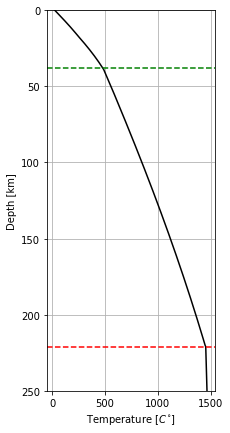

In [3]:
fig = plt.figure(figsize = (3,7))
ax = plt.subplot(111)
ax.plot(T-273.15,depth/1e3,color = 'k')
ax.axhline(moho,linestyle = '--', color = 'g')
ax.axhline(depth[idx_LAB]/1e3,linestyle = '--', color = 'r')
ax.set_ylim(0,250.0)
ax.grid(which = 'both')
ax.set_xlabel(r'Temperature [$C^{\circ}$]')
ax.set_ylabel('Depth [km]')
ax.invert_yaxis()
plt.show()


In [4]:
p_obj = pide.pide()

p_obj.set_temperature(T)
p_obj.set_pressure(p)

p_obj.set_composition_solid_mineral(ol = 0.6,opx = 0.25,cpx = 0.1, garnet= 0.05)
p_obj.set_bulk_water(100)
p_obj.mantle_water_distribute()
p_obj.set_mineral_conductivity_choice(ol = 4)
p_obj.set_solid_phs_mix_method(method = 1)
cond = p_obj.calculate_conductivity()

In [8]:
v_bulk, v_p, v_s = p_obj.calculate_seismic_velocities()
print(v_s)

[4.92594034 4.92187599 4.9178232  4.91374199 4.90964284 4.90553528
 4.90142853 4.89733123 4.89325169 4.8891977  4.8851766  4.88119528
 4.87726018 4.8733773  4.86955222 4.8657901  4.86209572 4.85847347
 4.8544061  4.85038319 4.84640654 4.84247869 4.83860199 4.83477864
 4.83101066 4.82729992 4.82364816 4.82005697 4.81652784 4.81306211
 4.80966105 4.80632579 4.80305739 4.79985681 4.79672492 4.7936625
 4.79067029 4.78774892 4.784899   4.78228054 4.78083971 4.7793967
 4.77795326 4.77650952 4.77506557 4.77362153 4.7721775  4.7707336
 4.76928992 4.76784657 4.76640364 4.76496124 4.76358287 4.76220539
 4.76082896 4.75945365 4.75807956 4.75670679 4.75533535 4.75396536
 4.75259689 4.75123001 4.7498648  4.74850132 4.74713965 4.74577985
 4.74442199 4.74306614 4.74171236 4.7403607  4.73901124 4.73766403
 4.73631913 4.7349766  4.73363649 4.73229886 4.73096377 4.72963127
 4.72830141 4.72697424 4.72564981 4.72432816 4.72300936 4.72169344
 4.72038045 4.71907044 4.71776345 4.71645952 4.71515869 4.7138610